### Hakaton 2025

Задача — семантический текстовый поиск
Цель и ожидаемый результат
Создать систему семантического текстового поиска слов (словосочетаний) в документах, учитывающую не только точное написание, но и смысловое значение.
Результатом должно быть определение позиции найденного слова/словосочетания в тексте и оценка вероятности совпадения.

Желательно реализовать примитивный веб-интерфейс (UI) для ручного тестирования.

Технические требования

Язык разработки — Python;
Все тексты — на русском языке, приведены к нижнему регистру, без пунктуации;
Максимальная длина документа — 30 слов;
Словосочетания — не более 2 слов в базовой форме;

# Презентация партнера 

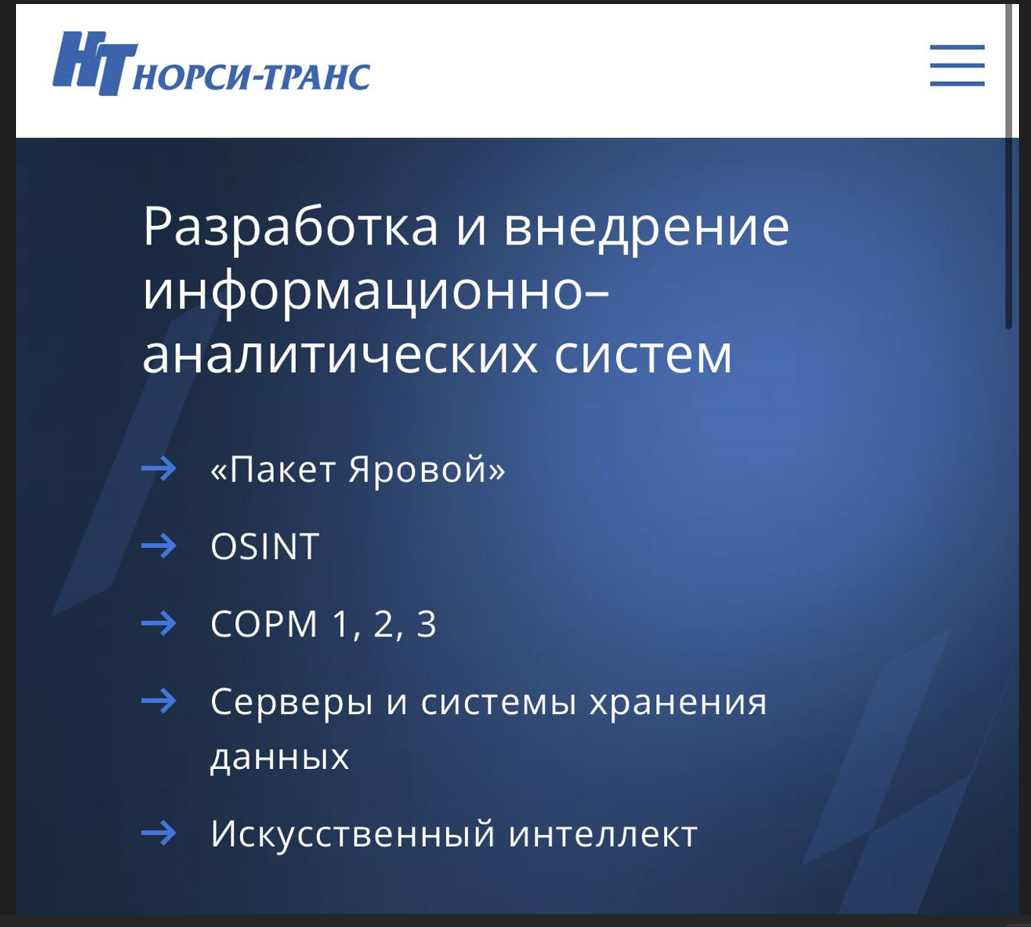

### Описание датасета

Набор данных взят из соцсетей в исходном виде, а значит нуждается в предобработке. К сожалению, мы не имеем права предоставить разметку, поэтому данные разделены просто на 6 csv файлов (как и количество классов). Каждая строка файла - это некоторый пост из соцсети. Пост может содержать исходный текст (то, что написал сам пользователь), текст на картинке, текст речи из видео. Поэтому файл имеет 3 колонки, разделенные знаком ",".

Колонка "doc_text" содержит исходный текст самого поста
Колонка "image2text" содержит текст, распознанный на изображении поста с помощью системы OCR
Колонка "speech2text" содержит текст речи, распознанной с помощью системы ASR  

Некоторые посты могут не иметь те или иные поля, т.е. содержат пустой текст

In [640]:
# Подключение библиотек

from sentence_transformers import CrossEncoder
from sentence_transformers import SentenceTransformer, util


import pandas as pd
import re



#### Исследование и предобраотка данных

In [641]:
# Загрузка данных из одного файла для исследования
file_path = "Data/1.csv"
data = pd.read_csv(file_path)

# Просмотр содержания файла
data.head()

doc_text  \
0  Твой лучший секс спрятан здесь 🔞  Делюсь канал...   
1  ⭐️  Кнопка: ⭐️START⭐️(https://t.me/major/start...   
2  А продолжение где? Правильно. В моем сообществ...   
3  Тем временем моя авторская телега уверенно в т...   
4  У меня есть двоюродная сестра, у нее есть сын ...   

                                          image2text speech2text  
0                                                NaN         NaN  
1                                                NaN         NaN  
2  девчонки не умеют переписываться sanille они э...         NaN  
3  10:42 nuil пул telegram ^ 51 142 подписчика 12...         NaN  
4  т с не ^ е z 8 * \"8 ничего не знала о стендап...         NaN

При первичном изучении данных, представлеенных для обработки следует, что данные разбиты 
на 3 отдельных стоблца, которые заполнены не равномерно, что выражено в наличии значений NaN в строках.

In [642]:
## Вывод сведений о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     1000 non-null   object
 1   image2text   568 non-null    object
 2   speech2text  338 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB


Как видно данные в 3 столбцах заполнены неравномерно. Для дальнейшей работы с данными необходимо заменить все значения NaN на пробелы. Указанное преобразование будет включено в функцию обработки исследуемого файла.

In [643]:
# Замена занчений NaN на пробелы
data = data.fillna(' ')
data.head()


doc_text  \
0  Твой лучший секс спрятан здесь 🔞  Делюсь канал...   
1  ⭐️  Кнопка: ⭐️START⭐️(https://t.me/major/start...   
2  А продолжение где? Правильно. В моем сообществ...   
3  Тем временем моя авторская телега уверенно в т...   
4  У меня есть двоюродная сестра, у нее есть сын ...   

                                          image2text speech2text  
0                                                                 
1                                                                 
2  девчонки не умеют переписываться sanille они э...              
3  10:42 nuil пул telegram ^ 51 142 подписчика 12...              
4  т с не ^ е z 8 * \"8 ничего не знала о стендап...

In [644]:
# Объединение всех трех колонок в одну для дальнейшей обработки
data = data['doc_text'] + ' ' + data['image2text'] + ' ' + data['speech2text']
data.head()


0    Твой лучший секс спрятан здесь 🔞  Делюсь канал...
1    ⭐️  Кнопка: ⭐️START⭐️(https://t.me/major/start...
2    А продолжение где? Правильно. В моем сообществ...
3    Тем временем моя авторская телега уверенно в т...
4    У меня есть двоюродная сестра, у нее есть сын ...
dtype: object

In [645]:

# Функция для обработки текста: приведение к нижнему регистру и удаление лишних символов

def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'[^а-я \s]', '', text)  # Удаление лишних символов (оставляем только буквы, цифры и пробелы)
    return text

# Применение функции ко всем строкам в датасете
data = data.to_frame()

data = data.applymap(lambda x: preprocess_text(x) if isinstance(x, str) else x)

# Просмотр первых строк обработанного датасета
data.head()

C:\Users\Eve\AppData\Local\Temp\ipykernel_20036\4229117020.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: preprocess_text(x) if isinstance(x, str) else x)


0
0  твой лучший секс спрятан здесь   делюсь канало...
1                                        кнопка     
2  а продолжение где правильно в моем сообществе ...
3  тем временем моя авторская телега уверенно в т...
4  у меня есть двоюродная сестра у нее есть сын а...

Именно в таком виде текст из каждой строки будет обработан моделью.

## Выбор и тестирование моделей

##### Партнером представлено описание результата работы модели:

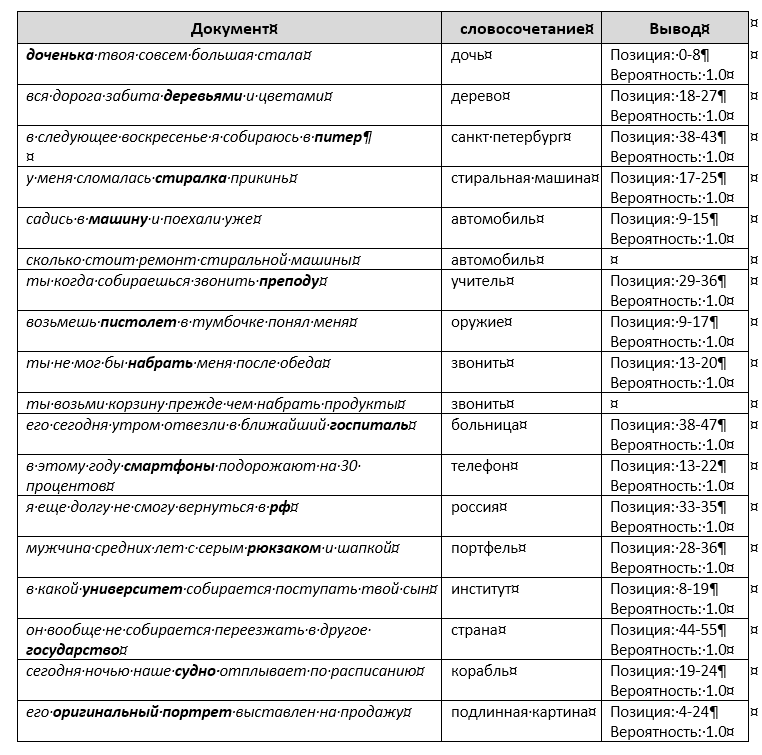

In [646]:
# На основании указанного файла сформирована тестовая выборка для проверки
# работы модели

## Тестовая выборка
documents = ['доченька твоя совсем большая стала',
             'вся дорога забита деревьями и цветами',
             'в следующее воскресенье я собираюсь в питер',
             'у меня сломалась стиралка прикинь',
             'садись в машину и поехали уже',
             'сколько стоит ремонт стиральной машины',
             'ты когда собираешься звонить преподу',
             'возьмешь пистолет в тумбочке понял меня',
             'ты не мог бы набрать меня после обеда',
             'ты возьми корзину прежде чем набрать продукты',
             'его сегодня утром отвезли в ближайший госпиталь',
             'в этому году смартфоны подорожают на 30 процентов',
             'я еще долгу не смогу вернуться в рф',
             'мужчина средних лет с серым рюкзаком и шапкой',
             'в какой университет собирается поступать твой сын',
             'он вообще не собирается переезжать в другое государство',
             'сегодня ночью наше судно отплывает по расписанию',
             'его оригинальный портрет выставлен на продажу']

# Слова для поиска в тексте
Words_to_search = ['дочь',
                   'дерево',
                   'санкт петербург',
                   'стиральная машина',
                   'автомобиль',
                   'автомобиль',
                   'учитель',
                   'оружие',
                   'звонить',
                   'звонить',
                   'больница',
                   'телефон',
                   'россия',
                   'портфель',
                   'институт',
                   'страна',
                   'корабль',
                   'подлинная картина']

#### Выбор модели для тестирования

Для исследования были выбраны предобученные модели, работающие на русском языке:

1. Модель: DiTy/cross-encoder-russian-msmarco;
2. Модель: paraphrase-MiniLM-L6-v2;
3. Модель: ai-forever/sbert_large_nlu_ru

В тестирования будут ичитываться правильность нахождение слова, похожего на искомое, а также метрики (вероятность) точности схожести слов.

##### Исследование модели DiTy/cross-encoder-russian-msmarco;

In [647]:
## Тестирование модели DiTy/cross-encoder-russian-msmarco

reranker_model = CrossEncoder(
    model_name_or_path="DiTy/cross-encoder-russian-msmarco",
    max_length=512
)

In [648]:
# Функция result для обработки текста и получения результата

def result(doc, query):
  doc_split = doc.split(' ')
  rank_result = reranker_model.rank(query, doc_split)
  start = ' '.join(doc_split).find(doc_split[rank_result[0]['corpus_id']])
  finish = start + len(doc_split[rank_result[0]['corpus_id']])
  return print(f"Позиция: {start}-{finish} {doc[start:finish]} \nВероятность: {round(rank_result[0]['score'], 2)}")

In [649]:
for pos in range(len(documents)):
  
  doc = documents[pos]
  query = Words_to_search[pos]

  print(documents[pos])
  print(Words_to_search[pos])

  result(doc, query)
  print('-------------------------------')

доченька твоя совсем большая стала
дочь
Позиция: 0-8 доченька 
Вероятность: 0.8199999928474426
-------------------------------
вся дорога забита деревьями и цветами
дерево
Позиция: 18-27 деревьями 
Вероятность: 0.800000011920929
-------------------------------
в следующее воскресенье я собираюсь в питер
санкт петербург
Позиция: 38-43 питер 
Вероятность: 0.14000000059604645
-------------------------------
у меня сломалась стиралка прикинь
стиральная машина
Позиция: 17-25 стиралка 
Вероятность: 0.5299999713897705
-------------------------------
садись в машину и поехали уже
автомобиль
Позиция: 9-15 машину 
Вероятность: 0.46000000834465027
-------------------------------
сколько стоит ремонт стиральной машины
автомобиль
Позиция: 32-38 машины 
Вероятность: 0.49000000953674316
-------------------------------
ты когда собираешься звонить преподу
учитель
Позиция: 29-36 преподу 
Вероятность: 0.4699999988079071
-------------------------------
возьмешь пистолет в тумбочке понял меня
оружие
Позиц

##### Исследование модели paraphrase-MiniLM-L6-v2;

In [650]:
# Загружаем предобученную модель
reranker_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [651]:
# Функция для поиска наиболее похожего слова в предложении 
# c использованием модели paraphrase-MiniLM-L6-v2
def find_most_similar_word(doc, query):
    # Разбиваем предложение на слова
    words = doc.split()
    
    # Преобразуем запрос и слова в эмбеддинги
    query_embedding = reranker_model.encode(query, convert_to_tensor=True)
    word_embeddings = reranker_model.encode(words, convert_to_tensor=True)
    
    # Вычисляем схожесть между запросом и каждым словом
    similarities = util.pytorch_cos_sim(query_embedding, word_embeddings)[0]
    
    # Находим индекс слова с максимальной схожестью
    max_index = similarities.argmax().item()
    max_score = similarities[max_index].item()
    
    # Определяем начальную и конечную позиции слова в предложении
    start_pos = doc.find(words[max_index])
    end_pos = start_pos + len(words[max_index])
    
    return words[max_index], max_score, start_pos, end_pos


for doc, query in zip(documents, Words_to_search):
    most_similar_word, score, start, end = find_most_similar_word(doc, query)
    print(f"Документ: {doc}")
    print(f"Слово для поиска: {query}")
    print(f"Найденное слово: {most_similar_word}")
    print(f"Схожесть: {score:.4f}")
    print(f"Позиция: {start}-{end}")
    print('-------------------------------')


Документ: доченька твоя совсем большая стала
Слово для поиска: дочь
Найденное слово: доченька
Схожесть: 0.8730
Позиция: 0-8
-------------------------------
Документ: вся дорога забита деревьями и цветами
Слово для поиска: дерево
Найденное слово: дорога
Схожесть: 0.9159
Позиция: 4-10
-------------------------------
Документ: в следующее воскресенье я собираюсь в питер
Слово для поиска: санкт петербург
Найденное слово: собираюсь
Схожесть: 0.8579
Позиция: 26-35
-------------------------------
Документ: у меня сломалась стиралка прикинь
Слово для поиска: стиральная машина
Найденное слово: сломалась
Схожесть: 0.9006
Позиция: 7-16
-------------------------------
Документ: садись в машину и поехали уже
Слово для поиска: автомобиль
Найденное слово: поехали
Схожесть: 0.8603
Позиция: 18-25
-------------------------------
Документ: сколько стоит ремонт стиральной машины
Слово для поиска: автомобиль
Найденное слово: стиральной
Схожесть: 0.8932
Позиция: 21-31
-------------------------------
Докумен

##### Исследование модели ai-forever/sbert_large_nlu_ru;

In [652]:
# Загружаем модель
model = SentenceTransformer('ai-forever/sbert_large_nlu_ru')

In [653]:
# Функция для поиска наиболее похожего слова
def find_most_similar_word(doc, query):
    # Разбиваем текст на слова
    words = doc.split()
    
    # Преобразуем запрос и слова в эмбеддинги
    query_embedding = model.encode(query, convert_to_tensor=True)
    word_embeddings = model.encode(words, convert_to_tensor=True)
    
    # Вычисляем схожесть между запросом и каждым словом
    similarities = util.pytorch_cos_sim(query_embedding, word_embeddings)[0]
    
    # Находим индекс слова с максимальной схожестью
    max_index = similarities.argmax().item()
    max_score = similarities[max_index].item()
    
    # Определяем начальную и конечную позиции слова в тексте
    start_pos = doc.find(words[max_index])
    end_pos = start_pos + len(words[max_index])
    
    return words[max_index], max_score, start_pos, end_pos

# Применяем функцию к каждому документу и запросу
for doc, query in zip(documents, Words_to_search):
    most_similar_word, score, start, end = find_most_similar_word(doc, query)
    print(f"Документ: {doc}")
    print(f"Запрос: {query}")
    print(f"Найденное слово: {most_similar_word}")
    print(f"Схожесть: {score:.4f}")
    print(f"Позиция: {start}-{end}")
    print('-------------------------------')

Документ: доченька твоя совсем большая стала
Запрос: дочь
Найденное слово: доченька
Схожесть: 0.7852
Позиция: 0-8
-------------------------------
Документ: вся дорога забита деревьями и цветами
Запрос: дерево
Найденное слово: деревьями
Схожесть: 0.6664
Позиция: 18-27
-------------------------------
Документ: в следующее воскресенье я собираюсь в питер
Запрос: санкт петербург
Найденное слово: питер
Схожесть: 0.9285
Позиция: 38-43
-------------------------------
Документ: у меня сломалась стиралка прикинь
Запрос: стиральная машина
Найденное слово: стиралка
Схожесть: 0.8822
Позиция: 17-25
-------------------------------
Документ: садись в машину и поехали уже
Запрос: автомобиль
Найденное слово: машину
Схожесть: 0.8909
Позиция: 9-15
-------------------------------
Документ: сколько стоит ремонт стиральной машины
Запрос: автомобиль
Найденное слово: машины
Схожесть: 0.8914
Позиция: 32-38
-------------------------------
Документ: ты когда собираешься звонить преподу
Запрос: учитель
Найденное 

#### Резульаты работы моделей: 

DiTy/cross-encoder-russian-msmarco
Правильно определено 16 слов из 18.

paraphrase-MiniLM-L6-v2
Правильно определено 4 слова из 18.

ai-forever/sbert_large_nlu_ru
Правильно определено 16 слов из 18.

Далее в проекте будет использоваться 
предобученная модель: DiTy/cross-encoder-russian-msmarco 
как наиболее точная.


### Тестирование на файлах партнера (Relise)

In [654]:
# Загрузка данных из файла 1.csv
file_path = "Data/1.csv"
data = pd.read_csv(file_path)
data = data.fillna(' ')
data = data['doc_text'] + ' ' + data['image2text'] + ' ' + data['speech2text']

# Применение функции ко всем строкам в датасете
data = data.to_frame()

data = data.applymap(lambda x: preprocess_text(x) if isinstance(x, str) else x)


# Просмотр первых строк загруженного файла
data.head()

C:\Users\Eve\AppData\Local\Temp\ipykernel_20036\2455275959.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: preprocess_text(x) if isinstance(x, str) else x)


0
0  твой лучший секс спрятан здесь   делюсь канало...
1                                        кнопка     
2  а продолжение где правильно в моем сообществе ...
3  тем временем моя авторская телега уверенно в т...
4  у меня есть двоюродная сестра у нее есть сын а...

In [655]:
relise_reranker_model = CrossEncoder(
    model_name_or_path="DiTy/cross-encoder-russian-msmarco",
    max_length=512
)

In [656]:
def relise_result(doc, query):
	doc_split = doc.split(' ')
	rank_result = relise_reranker_model.rank(query, doc_split)
	start = ' '.join(doc_split).find(doc_split[rank_result[0]['corpus_id']])
	finish = start + len(doc_split[rank_result[0]['corpus_id']])
	
	with open("logs.txt", "a", encoding="utf-8") as file: 
		file.write(f"Документ: {doc}\n")
		file.write(f"Запрос: {query}\n")
		file.write(f"Позиция: {start}-{finish} {doc[start:finish]}\n")
		file.write(f"Вероятность: {round(rank_result[0]['score'], 2)}\n")
		file.write("-------------------------------\n")
		
	# Сохранение результата в файл match.txt, если вероятность выше 80
	if rank_result[0]['score'] > 0.80:
		with open("match.txt", "a", encoding="utf-8") as match_file:
			match_file.write(f"Документ: {doc}\n")
			match_file.write(f"Запрос: {query}\n")
			match_file.write(f"Позиция: {start}-{finish} {doc[start:finish]}\n")
			match_file.write(f"Вероятность: {round(rank_result[0]['score'], 2)}\n")
			match_file.write("-------------------------------\n")

	return print(f"Позиция: {start}-{finish} {doc[start:finish]} \nВероятность: {round(rank_result[0]['score'], 2)}")

In [657]:
def split_into_fragments(text, max_words=30): # Функция для разбиения текста на фрагменты по 30 слов
		words = text.split()
		fragments = [' '.join(words[i:i + max_words]) for i in range(0, len(words), max_words)]
		return fragments

In [658]:
Words_to_search_relise = ['секс', 'порно', 'наркотик', 'оружие', 'таро', 'убийство']

In [659]:

for index, row in data.iterrows():
	row_text = row[0]  # Получаем текст строки
	print('-------------------------------')
	print(f"Обработка строки {index}: {row_text}")
	print(f"Длина строки: {len(row_text)}")
	print('Получены фрагменты:')

	fragments = split_into_fragments(row_text)
	for fragment in fragments:
		for word in Words_to_search_relise:
			print(f' Исследуется фрагмент: {fragment}')
			print(f' Слово для поиска: {word}')
			
			relise_result(fragment, word)

			print('-------------------------------')

-------------------------------
Обработка строки 0: твой лучший секс спрятан здесь   делюсь каналом дипломированного сексолога крис взломала код классного секса мастерски раскрепощает знает миллион горячих техник и лучшие девайсы для взрослых   самые полезные посты здесь   отрезвляющий пост я все сама   прокачай наездницу  ролевая игра  кинотеатр   техника оральных ласк    как занимается сксом неудобная женщина   кстати крис провела трехдневный безоплатный онлайн интенсивот бревна до богини совместно с врачом и владельцем сексшопа   скорее смотри записи пока не удалила      здесь жарче чем в аду     
Длина строки: 555
Получены фрагменты:
 Исследуется фрагмент: твой лучший секс спрятан здесь делюсь каналом дипломированного сексолога крис взломала код классного секса мастерски раскрепощает знает миллион горячих техник и лучшие девайсы для взрослых самые полезные посты здесь отрезвляющий
 Слово для поиска: секс
Позиция: 12-16 секс 
Вероятность: 0.8299999833106995
-------------------------

KeyboardInterrupt: 